#####  creates an height-latitude/height-longitude cross-section at a specific longitude/latitude.
  
- Read MPAS diag data
- Extract cross-sections along constant latitude/longitude lines
- Plot temperature cross-sections along constant latitude/longitude lines
 
Ming Ge May 2025

In [1]:
import numpy as np
import uxarray as ux
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.ticker import (NullFormatter, ScalarFormatter)
from holoviews import opts
import holoviews as hv
# Tell HoloViews (and hvplot) to use the Matplotlib backend for rendering plots
hv.extension( "matplotlib")

from scipy import interpolate
%matplotlib inline

In [2]:
def plot_cross_sec(xmin, xmax, n_x, height_1d, data_2d, title_s):
    '''
    plot cross-section of lat/lon - P
    xmin: minimum value of x axis
    xmax: maximum value of x axis
    n_x: evenly spaced points between xmin and xmax
    '''
    # Create the figure
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()

    # Make the contour plot
    t_cs = ax.contourf(np.linspace(xmin, xmax, n_x), height_1d, data_2d, 
                                   cmap='YlGnBu_r')

    # Add the color bar
    plt.colorbar(t_cs, ax=ax)

    # Set the y-ticks to be height and adjust the y-axis to be logarithmic
    ax.set_yscale('symlog')
    ax.set_ylim(height_1d[-1], height_1d[0])
    ax.set_yticks(height_1d)
    ax.set_yticklabels(height_1d, fontsize=12)
    ax.set_ylabel("height (hPa)", fontsize=12)
    plt.title(title_s, fontsize=16 );
    plt.show()

#### Read diag grid and data using uxarray

In [3]:
dir_data = "/glade/campaign/mmm/c3we/mingge/MPAS_PROJ/mpas_tutorial/240-48km_variable/"
flnm_grid = dir_data + "SouthAmerica.init.nc"
flnm_data = dir_data + "diag.2014-09-14_12.00.00.nc"

uxds = ux.open_dataset(flnm_grid, flnm_data)
uxgrid = uxds.uxgrid 

#### Extract cross-sections from an unstructured grid  

In [4]:
height_1d = [50,100,200,250, 500,700,850,925]

n_lev = len(height_1d)
n_cell = len(uxds.n_face.data)

# Cross-sections along constant latitude/longitude
lat = 0
# Longitude must be between -180 and 180 degrees.
lon = -80

for nl in range(n_lev):
    w_var = 'temperature_' + str(height_1d[nl]) + 'hPa'
    #w_var = 'w_' + str(height_1d[nl]) + 'hPa'
    # Cross-sections along constant latitude  lines
    ww_Clat = uxds[w_var].cross_section.constant_latitude(lat)
    # Cross-sections along constant longitude lines
    ww_Clon = uxds[w_var].cross_section.constant_longitude(lon)
    if nl==0:
        n_lon = ww_Clat.shape[1]
        n_lat = ww_Clon.shape[1]
        w_lat_2d = np.zeros((n_lev, n_lat))
        w_lon_2d = np.zeros((n_lev, n_lon))

    w_lat_2d[nl] = ww_Clon[0]
    w_lon_2d[nl] = ww_Clat[0]


In [5]:
face_lat = ww_Clon.uxgrid.face_lat
face_lon = ww_Clat.uxgrid.face_lon

#### Plot temperature cross-sections along constant longitude lines 

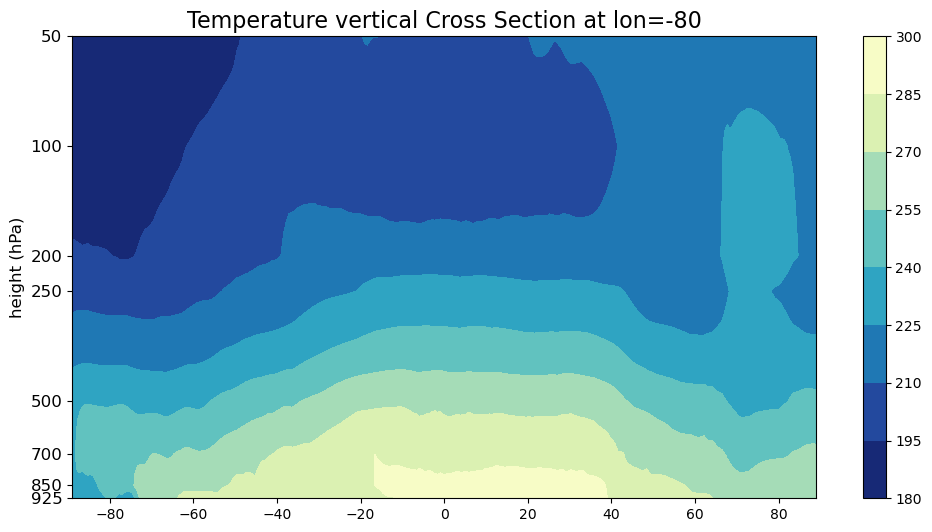

In [6]:
%matplotlib inline
 
# # interpolate to evenly spaced points between lat_min and lat_max
w_lat_2d_new = w_lat_2d.copy()
for nl in range(n_lev):
    ff = interpolate.interp1d(face_lat, w_lat_2d[nl])
    w_lat_2d_new[nl] = ff(np.linspace(-89, 89, len(face_lat))) 

title_s = "Temperature vertical Cross Section at lon=" + str(lon)
plot_cross_sec(-89, 89, len(face_lat), height_1d, w_lat_2d_new, title_s)

#### Plot temperature cross-sections along constant latitude lines 

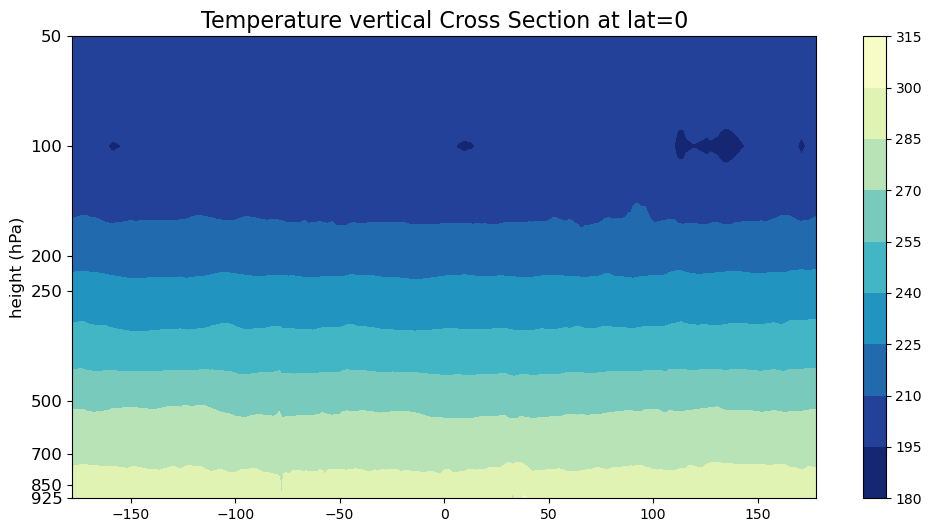

In [7]:
# interpolate to evenly spaced points between lon_min and lon_max
w_lon_2d_new = w_lon_2d.copy()
for nl in range(n_lev):
    ff = interpolate.interp1d(face_lon, w_lon_2d[nl])
    w_lon_2d_new[nl] = ff(np.linspace(-178, 178, len(face_lon))) 

title_s = "Temperature vertical Cross Section at lat=" + str(lat)
plot_cross_sec(-178, 178, len(face_lon), height_1d, w_lon_2d_new, title_s)